# Trader Sentiment Analysis



## 1. Setup and Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load Datasets

In [3]:
# Load Fear & Greed Index data
sentiment_df = pd.read_csv('/content/drive/MyDrive/primetrade/fear_greed_index.csv')

# Load Trading data
trades_df = pd.read_csv('/content/drive/MyDrive/primetrade/historical_data.csv')

print("="*70)
print("SENTIMENT DATA (Fear & Greed Index)")
print("="*70)
print(f"Shape: {sentiment_df.shape}")
print(f"Columns: {list(sentiment_df.columns)}")
print(f"Date range: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")
print("\nFirst 5 rows:")
display(sentiment_df.head())

print("\n" + "="*70)
print("TRADING DATA")
print("="*70)
print(f"Shape: {trades_df.shape}")
print(f"Columns: {list(trades_df.columns)}")
print("\nFirst 5 rows:")
display(trades_df.head())

SENTIMENT DATA (Fear & Greed Index)
Shape: (2644, 4)
Columns: ['timestamp', 'value', 'classification', 'date']
Date range: 2018-02-01 to 2025-05-02

First 5 rows:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



TRADING DATA
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

First 5 rows:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,7872.16,BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,895000000000000.00,1730000000000.00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,443000000000000.00,1730000000000.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,1150.63,BUY,02-12-2024 22:50,1002.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,660000000000000.00,1730000000000.00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,1142.04,BUY,02-12-2024 22:50,1146.56,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,1080000000000000.00,1730000000000.00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,1289.49,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,1050000000000000.00,1730000000000.00


## 3. Data Cleaning and Preparation

In [4]:
# Clean sentiment data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_clean = sentiment_df[['date', 'value', 'classification']].copy()
sentiment_clean.columns = ['date', 'sentiment_value', 'sentiment_category']

print("Sentiment categories:")
print(sentiment_clean['sentiment_category'].value_counts())


Sentiment categories:
sentiment_category
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [5]:
# Clean trading data
# Extract date from Timestamp IST for joining
trades_df['trade_date'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
trades_df['trade_date'] = pd.to_datetime(trades_df['trade_date'])

# Keep the timestamp for time-based analysis
trades_df['trade_datetime'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

print("Trading data info:")
print(f"Total trades: {len(trades_df):,}")
print(f"Date range: {trades_df['trade_date'].min()} to {trades_df['trade_date'].max()}")
print(f"Unique sides: {trades_df['Side'].unique()}")
print(f"\nTrades by side:")
print(trades_df['Side'].value_counts())

Trading data info:
Total trades: 211,224
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Unique sides: ['BUY' 'SELL']

Trades by side:
Side
SELL    108528
BUY     102696
Name: count, dtype: int64


## 4. Create Trading Metrics

- **Trade Frequency**: Number of trades per day
- **Position Sizes**: Average trade size (in USD and tokens)
- **Long/Short Bias**: Ratio and count of buy vs sell trades
- **PnL Metrics**: Daily profit/loss
- **Trading Activity**: Volume, number of orders, etc.

In [6]:
# Calculate daily trading metrics
daily_metrics = trades_df.groupby('trade_date').agg({
    # Trade Frequency
    'Trade ID': 'count',  # Number of trades per day

    # Position Sizes
    'Size USD': ['mean', 'median', 'sum', 'std'],
    'Size Tokens': ['mean', 'sum'],

    # PnL
    'Closed PnL': ['sum', 'mean'],

    # Price metrics
    'Execution Price': ['mean', 'min', 'max'],

    # Fees
    'Fee': 'sum',

    # Position tracking
    'Start Position': ['first', 'last']
}).reset_index()

# Flatten column names
daily_metrics.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                         for col in daily_metrics.columns.values]

# Rename for clarity
daily_metrics.rename(columns={
    'trade_date': 'date',
    'Trade ID_count': 'trade_frequency',
    'Size USD_mean': 'avg_position_size_usd',
    'Size USD_median': 'median_position_size_usd',
    'Size USD_sum': 'total_volume_usd',
    'Size USD_std': 'position_size_std_usd',
    'Size Tokens_mean': 'avg_position_size_tokens',
    'Size Tokens_sum': 'total_volume_tokens',
    'Closed PnL_sum': 'daily_pnl',
    'Closed PnL_mean': 'avg_pnl_per_trade',
    'Execution Price_mean': 'avg_execution_price',
    'Execution Price_min': 'min_execution_price',
    'Execution Price_max': 'max_execution_price',
    'Fee_sum': 'total_fees',
    'Start Position_first': 'start_of_day_position',
    'Start Position_last': 'end_of_day_position'
}, inplace=True)

print("Daily metrics created:")
print(f"Shape: {daily_metrics.shape}")
display(daily_metrics.head())

Daily metrics created:
Shape: (480, 16)


,date,trade_frequency,avg_position_size_usd,median_position_size_usd,total_volume_usd,position_size_std_usd,avg_position_size_tokens,total_volume_tokens,daily_pnl,avg_pnl_per_trade,avg_execution_price,min_execution_price,max_execution_price,total_fees,start_of_day_position,end_of_day_position
0,2023-05-01,3,159.00,156.39,477.00,23.33,0.08,0.25,0.00,0.00,1898.13,1897.90,1898.60,0.00,0.00,0.18
1,2023-12-05,9,5556.20,1935.95,50005.83,7684.93,1.31,11.81,0.00,0.00,11038.30,2230.10,41867.00,12.50,0.00,-0.01
2,2023-12-14,11,10291.21,8677.28,113203.35,7791.14,372.03,4092.29,-205.43,-18.68,8031.87,2.97,42749.00,28.30,-0.60,-2237.00
3,2023-12-15,2,5304.98,5304.98,10609.95,1927.25,1779.00,3558.00,-24.63,-12.32,2.98,2.98,2.98,2.65,-3558.00,-1322.00
4,2023-12-16,3,5116.26,4680.14,15348.77,797.04,13299.00,39897.00,0.00,0.00,0.38,0.38,0.38,3.84,0.00,24208.00


In [7]:
# Calculate Long/Short Bias metrics
long_short_metrics = trades_df.groupby('trade_date').apply(
    lambda x: pd.Series({
        'buy_trades': (x['Side'] == 'BUY').sum(),
        'sell_trades': (x['Side'] == 'SELL').sum(),
        'buy_volume_usd': x[x['Side'] == 'BUY']['Size USD'].sum(),
        'sell_volume_usd': x[x['Side'] == 'SELL']['Size USD'].sum(),
        'buy_volume_tokens': x[x['Side'] == 'BUY']['Size Tokens'].sum(),
        'sell_volume_tokens': x[x['Side'] == 'SELL']['Size Tokens'].sum(),
    })
).reset_index()

long_short_metrics.rename(columns={'trade_date': 'date'}, inplace=True)

# Calculate ratios
long_short_metrics['long_short_ratio_count'] = (
    long_short_metrics['buy_trades'] /
    (long_short_metrics['sell_trades'] + 1)
)

long_short_metrics['long_short_ratio_volume'] = (
    long_short_metrics['buy_volume_usd'] /
    (long_short_metrics['sell_volume_usd'] + 1)
)

# Calculate net position bias
long_short_metrics['net_volume_usd'] = (
    long_short_metrics['buy_volume_usd'] - long_short_metrics['sell_volume_usd']
)

long_short_metrics['net_volume_tokens'] = (
    long_short_metrics['buy_volume_tokens'] - long_short_metrics['sell_volume_tokens']
)

# Calculate percentage of buy trades
long_short_metrics['buy_percentage'] = (
    long_short_metrics['buy_trades'] /
    (long_short_metrics['buy_trades'] + long_short_metrics['sell_trades']) * 100
)

print("Long/Short bias metrics created:")
print(f"Shape: {long_short_metrics.shape}")
display(long_short_metrics.head())

Long/Short bias metrics created:
Shape: (480, 12)


,date,buy_trades,sell_trades,buy_volume_usd,sell_volume_usd,buy_volume_tokens,sell_volume_tokens,long_short_ratio_count,long_short_ratio_volume,net_volume_usd,net_volume_tokens,buy_percentage
0,2023-05-01,3.00,0.00,477.00,0.00,0.25,0.00,3.00,477.00,477.00,0.25,100.00
1,2023-12-05,7.00,2.00,25007.21,24998.62,11.21,0.60,2.33,1.00,8.59,10.61,77.78
2,2023-12-14,5.00,6.00,51407.47,61795.88,261.84,3830.45,0.71,0.83,-10388.41,-3568.61,45.45
3,2023-12-15,2.00,0.00,10609.95,0.00,3558.00,0.00,2.00,10609.95,10609.95,3558.00,100.00
4,2023-12-16,3.00,0.00,15348.77,0.00,39897.00,0.00,3.00,15348.77,15348.77,39897.00,100.00


In [8]:
# we will calculate an ESTIMATED leverage based on position size vs capital

# Implied Leverage ≈ Position Size USD / (Position Size USD / Typical Margin Ratio)
# We'll use a simplified approach based on position changes

leverage_metrics = trades_df.groupby('trade_date').apply(
    lambda x: pd.Series({
        'max_position_usd': x['Size USD'].max(),
        'position_range_usd': x['Size USD'].max() - x['Size USD'].min(),
        # Implied leverage (estimated): larger positions relative to average suggest higher leverage
        'implied_leverage_factor': x['Size USD'].max() / (x['Size USD'].mean() + 1)
    })
).reset_index()

leverage_metrics.rename(columns={'trade_date': 'date'}, inplace=True)

print("Estimated leverage metrics created:")
print(f"Shape: {leverage_metrics.shape}")
display(leverage_metrics.head())

Estimated leverage metrics created:
Shape: (480, 4)


,date,max_position_usd,position_range_usd,implied_leverage_factor
0,2023-05-01,183.53,46.45,1.15
1,2023-12-05,24370.62,23813.10,4.39
2,2023-12-14,25252.56,24611.34,2.45
3,2023-12-15,6667.75,2725.55,1.26
4,2023-12-16,6036.19,1403.75,1.18


## 5. Merge All Metrics Together

In [9]:
# Merge daily metrics with long/short metrics
combined_metrics = daily_metrics.merge(long_short_metrics, on='date', how='left')

# Merge with leverage metrics
combined_metrics = combined_metrics.merge(leverage_metrics, on='date', how='left')

print("Combined trading metrics:")
print(f"Shape: {combined_metrics.shape}")
print(f"Columns: {len(combined_metrics.columns)}")
print("\nColumn list:")
for i, col in enumerate(combined_metrics.columns, 1):
    print(f"{i:2d}. {col}")

print("\nFirst few rows:")
display(combined_metrics.head())

Combined trading metrics:
Shape: (480, 30)
Columns: 30

Column list:
 1. date
 2. trade_frequency
 3. avg_position_size_usd
 4. median_position_size_usd
 5. total_volume_usd
 6. position_size_std_usd
 7. avg_position_size_tokens
 8. total_volume_tokens
 9. daily_pnl
10. avg_pnl_per_trade
11. avg_execution_price
12. min_execution_price
13. max_execution_price
14. total_fees
15. start_of_day_position
16. end_of_day_position
17. buy_trades
18. sell_trades
19. buy_volume_usd
20. sell_volume_usd
21. buy_volume_tokens
22. sell_volume_tokens
23. long_short_ratio_count
24. long_short_ratio_volume
25. net_volume_usd
26. net_volume_tokens
27. buy_percentage
28. max_position_usd
29. position_range_usd
30. implied_leverage_factor

First few rows:


,date,trade_frequency,avg_position_size_usd,median_position_size_usd,total_volume_usd,position_size_std_usd,avg_position_size_tokens,total_volume_tokens,daily_pnl,avg_pnl_per_trade,avg_execution_price,min_execution_price,max_execution_price,total_fees,start_of_day_position,end_of_day_position,buy_trades,sell_trades,buy_volume_usd,sell_volume_usd,buy_volume_tokens,sell_volume_tokens,long_short_ratio_count,long_short_ratio_volume,net_volume_usd,net_volume_tokens,buy_percentage,max_position_usd,position_range_usd,implied_leverage_factor
0,2023-05-01,3,159.00,156.39,477.00,23.33,0.08,0.25,0.00,0.00,1898.13,1897.90,1898.60,0.00,0.00,0.18,3.00,0.00,477.00,0.00,0.25,0.00,3.00,477.00,477.00,0.25,100.00,183.53,46.45,1.15
1,2023-12-05,9,5556.20,1935.95,50005.83,7684.93,1.31,11.81,0.00,0.00,11038.30,2230.10,41867.00,12.50,0.00,-0.01,7.00,2.00,25007.21,24998.62,11.21,0.60,2.33,1.00,8.59,10.61,77.78,24370.62,23813.10,4.39
2,2023-12-14,11,10291.21,8677.28,113203.35,7791.14,372.03,4092.29,-205.43,-18.68,8031.87,2.97,42749.00,28.30,-0.60,-2237.00,5.00,6.00,51407.47,61795.88,261.84,3830.45,0.71,0.83,-10388.41,-3568.61,45.45,25252.56,24611.34,2.45
3,2023-12-15,2,5304.98,5304.98,10609.95,1927.25,1779.00,3558.00,-24.63,-12.32,2.98,2.98,2.98,2.65,-3558.00,-1322.00,2.00,0.00,10609.95,0.00,3558.00,0.00,2.00,10609.95,10609.95,3558.00,100.00,6667.75,2725.55,1.26
4,2023-12-16,3,5116.26,4680.14,15348.77,797.04,13299.00,39897.00,0.00,0.00,0.38,0.38,0.38,3.84,0.00,24208.00,3.00,0.00,15348.77,0.00,39897.00,0.00,3.00,15348.77,15348.77,39897.00,100.00,6036.19,1403.75,1.18


## 6. Join with Sentiment Data

In [10]:
# Merge trading metrics with sentiment data
final_dataset = combined_metrics.merge(sentiment_clean, on='date', how='left')

# Check for missing sentiment data
missing_sentiment = final_dataset['sentiment_category'].isna().sum()

print("="*70)
print("FINAL MERGED DATASET")
print("="*70)
print(f"Shape: {final_dataset.shape}")
print(f"Date range: {final_dataset['date'].min()} to {final_dataset['date'].max()}")
print(f"\nMissing sentiment data: {missing_sentiment} days")

if missing_sentiment > 0:
    print(final_dataset[final_dataset['sentiment_category'].isna()]['date'].tolist())

# Remove rows without sentiment (optional)
final_dataset_clean = final_dataset.dropna(subset=['sentiment_category']).copy()

print(f"\nAfter removing missing sentiment: {final_dataset_clean.shape}")
print("\nSentiment distribution:")
print(final_dataset_clean['sentiment_category'].value_counts())

print("\nFirst 10 rows:")
display(final_dataset_clean.head(10))

FINAL MERGED DATASET
Shape: (480, 32)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Missing sentiment data: 1 days
[Timestamp('2024-10-26 00:00:00')]

After removing missing sentiment: (479, 32)

Sentiment distribution:
sentiment_category
Greed            193
Extreme Greed    114
Fear              91
Neutral           67
Extreme Fear      14
Name: count, dtype: int64

First 10 rows:


,date,trade_frequency,avg_position_size_usd,median_position_size_usd,total_volume_usd,position_size_std_usd,avg_position_size_tokens,total_volume_tokens,daily_pnl,avg_pnl_per_trade,avg_execution_price,min_execution_price,max_execution_price,total_fees,start_of_day_position,end_of_day_position,buy_trades,sell_trades,buy_volume_usd,sell_volume_usd,buy_volume_tokens,sell_volume_tokens,long_short_ratio_count,long_short_ratio_volume,net_volume_usd,net_volume_tokens,buy_percentage,max_position_usd,position_range_usd,implied_leverage_factor,sentiment_value,sentiment_category
0,2023-05-01,3,159.00,156.39,477.00,23.33,0.08,0.25,0.00,0.00,1898.13,1897.90,1898.60,0.00,0.00,0.18,3.00,0.00,477.00,0.00,0.25,0.00,3.00,477.00,477.00,0.25,100.00,183.53,46.45,1.15,63.00,Greed
1,2023-12-05,9,5556.20,1935.95,50005.83,7684.93,1.31,11.81,0.00,0.00,11038.30,2230.10,41867.00,12.50,0.00,-0.01,7.00,2.00,25007.21,24998.62,11.21,0.60,2.33,1.00,8.59,10.61,77.78,24370.62,23813.10,4.39,75.00,Extreme Greed
2,2023-12-14,11,10291.21,8677.28,113203.35,7791.14,372.03,4092.29,-205.43,-18.68,8031.87,2.97,42749.00,28.30,-0.60,-2237.00,5.00,6.00,51407.47,61795.88,261.84,3830.45,0.71,0.83,-10388.41,-3568.61,45.45,25252.56,24611.34,2.45,72.00,Greed
3,2023-12-15,2,5304.98,5304.98,10609.95,1927.25,1779.00,3558.00,-24.63,-12.32,2.98,2.98,2.98,2.65,-3558.00,-1322.00,2.00,0.00,10609.95,0.00,3558.00,0.00,2.00,10609.95,10609.95,3558.00,100.00,6667.75,2725.55,1.26,70.00,Greed
4,2023-12-16,3,5116.26,4680.14,15348.77,797.04,13299.00,39897.00,0.00,0.00,0.38,0.38,0.38,3.84,0.00,24208.00,3.00,0.00,15348.77,0.00,39897.00,0.00,3.00,15348.77,15348.77,39897.00,100.00,6036.19,1403.75,1.18,67.00,Greed
5,2023-12-17,14,8305.57,5368.02,116278.02,9857.56,6160.46,86246.45,304.98,21.78,802.54,0.39,2246.40,29.07,39897.00,1779.60,3.00,11.00,50312.21,65965.81,23174.72,63071.72,0.25,0.76,-15653.60,-39897.00,21.43,30572.93,30522.84,3.68,73.00,Greed
6,2023-12-18,2,15582.09,15582.09,31164.18,22011.77,7.15,14.31,0.00,0.00,2178.10,2177.80,2178.40,7.79,0.00,0.01,2.00,0.00,31164.18,0.00,14.31,0.00,2.00,31164.18,31164.18,14.31,100.00,31146.76,31129.34,2.00,65.00,Greed
7,2023-12-19,15,6106.83,4728.67,91602.41,6873.37,10769.75,161546.31,1000.54,66.70,447.80,0.37,2237.60,22.90,14.31,8076.00,5.00,10.00,29718.92,61883.49,80766.00,80780.31,0.45,0.48,-32164.57,-14.31,33.33,27346.85,27288.42,4.48,73.00,Greed
8,2023-12-20,18,7868.71,7686.93,141636.79,5292.15,9695.57,174520.20,162.73,9.04,6.72,0.36,11.82,35.41,0.00,12928.00,10.00,8.00,70737.04,70899.75,87260.10,87260.10,1.11,1.00,-162.71,0.00,55.56,23605.58,23515.71,3.00,74.00,Greed
9,2023-12-21,49,2555.80,2182.45,125233.97,1575.72,27.84,1364.30,537.21,10.96,91.84,90.77,93.53,31.31,0.00,23.68,22.00,27.00,62348.40,62885.57,682.15,682.15,0.79,0.99,-537.17,-0.00,44.90,6308.51,6283.74,2.47,70.00,Greed


## 7. Summary Statistics by Sentiment

In [11]:
# Group metrics by sentiment category
sentiment_summary = final_dataset_clean.groupby('sentiment_category').agg({
    'trade_frequency': ['mean', 'median', 'sum'],
    'avg_position_size_usd': ['mean', 'median'],
    'total_volume_usd': ['mean', 'sum'],
    'daily_pnl': ['mean', 'median', 'sum'],
    'long_short_ratio_count': ['mean', 'median'],
    'buy_percentage': ['mean', 'median'],
    'implied_leverage_factor': ['mean', 'median'],
    'total_fees': ['mean', 'sum']
}).round(2)

print("="*70)
print("SUMMARY STATISTICS BY SENTIMENT")
print("="*70)
display(sentiment_summary)

SUMMARY STATISTICS BY SENTIMENT


trade_frequency                avg_position_size_usd  \
                              mean  median    sum                  mean   
sentiment_category                                                        
Extreme Fear               1528.57 1097.50  21400               4091.80   
Extreme Greed               350.81  133.00  39992               4410.52   
Fear                        679.53   88.00  61837               6524.29   
Greed                       260.64   47.00  50303               6735.30   
Neutral                     562.48   50.00  37686               7157.53   

                           total_volume_usd              daily_pnl           \
                    median             mean          sum      mean   median   
sentiment_category                                                            
Extreme Fear       4236.13       8177447.25 114484261.44  52793.59 22561.74   
Extreme Greed      3418.98       1091799.69 124465164.57  23817.29  3127.54   
Fear               4186.97       5311261.43 483324789.79  36891.82  1412.31   
Greed              5304.98       1495246.09 288582494.72  11140.57   678.48   
Neutral            6000.24       2690180.05 180242063.08  19297.32  1818.57   

                              long_short_ratio_count        buy_percentage  \
                          sum                   mean median           mean   
sentiment_category                                                           
Extreme Fear        739110.25                   1.14   1.01          48.65   
Extreme Greed      2715171.31                   1.69   0.78          45.68   
Fear               3357155.44                   3.23   1.00          51.35   
Greed              2150129.27                   2.72   0.83          49.35   
Neutral            1292920.68                   2.53   1.03          49.98   

                          implied_leverage_factor        total_fees           
                   median                    mean median       mean      sum  
sentiment_category                                                            
Extreme Fear        51.15                   79.89  74.06    1706.33 23888.63  
Extreme Greed       43.88                   23.18  14.42     237.11 27030.67  
Fear                51.25                   44.46  11.75    1016.01 92456.95  
Greed               46.67                   19.05   6.34     326.94 63098.69  
Neutral             50.74                   32.77   8.87     587.68 39374.27

## 8. Key Metrics Visualization

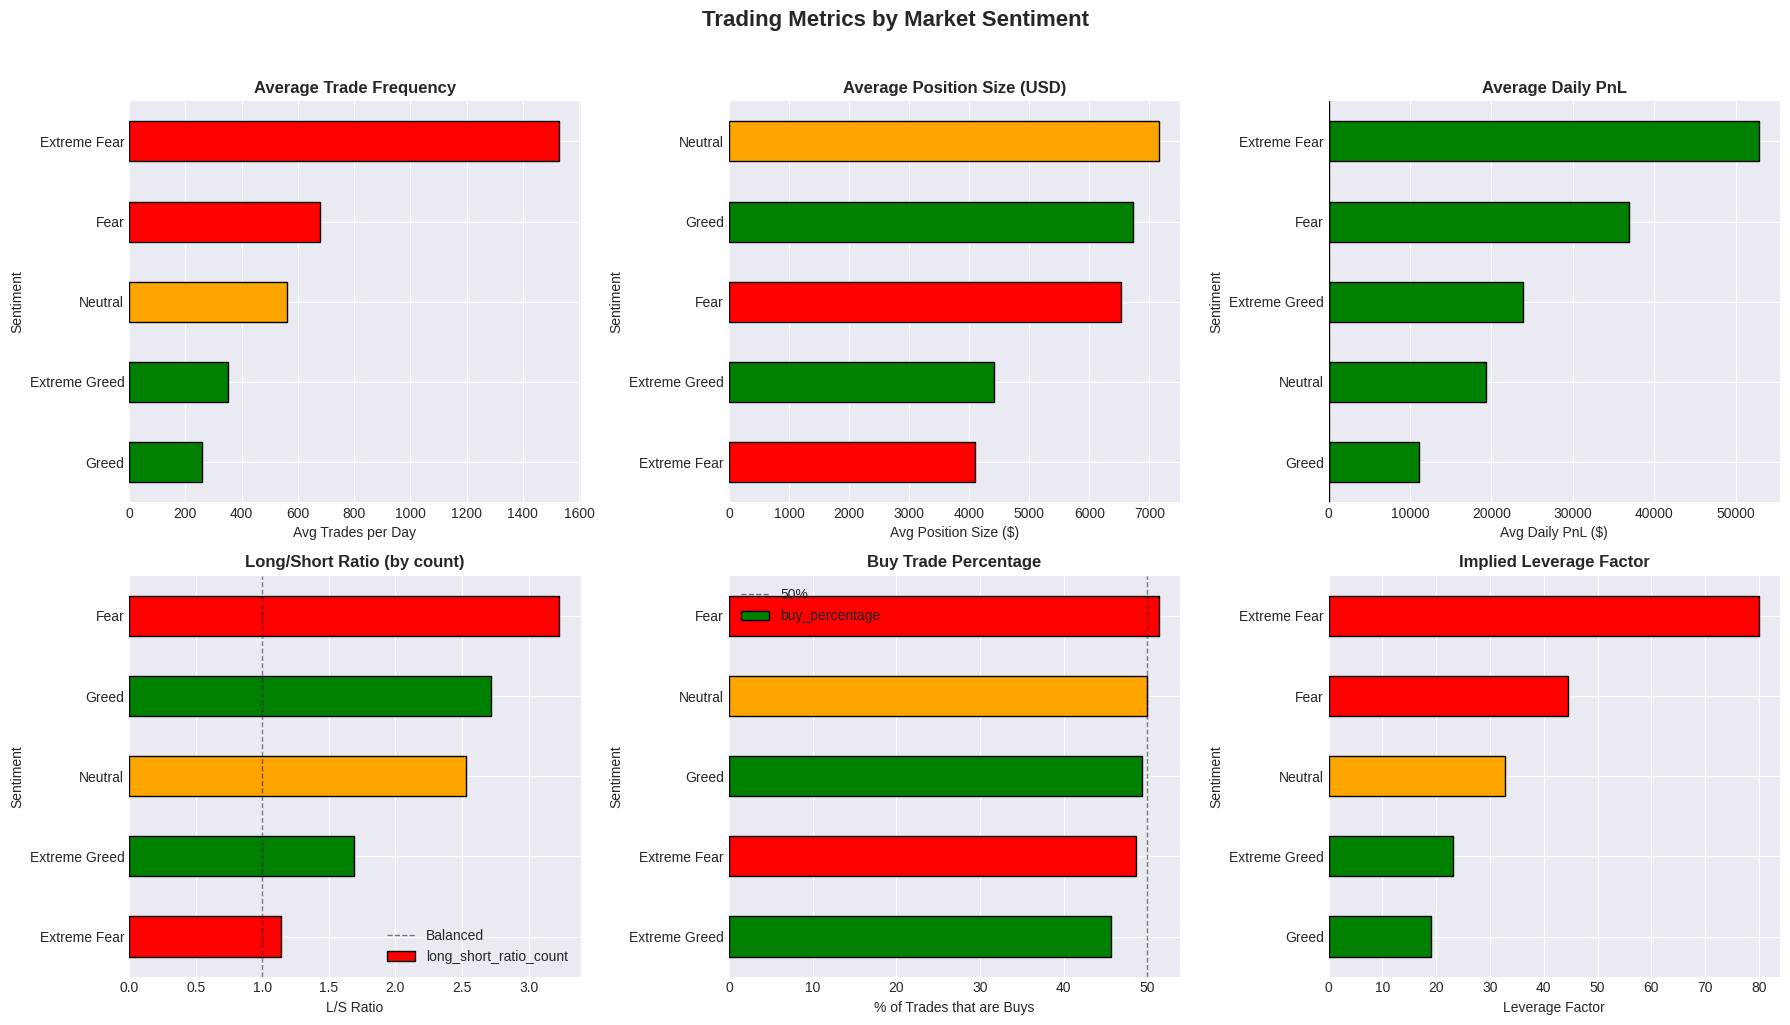

In [12]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Trading Metrics by Market Sentiment', fontsize=16, fontweight='bold', y=1.02)

# 1. Trade Frequency by Sentiment
sentiment_groups = final_dataset_clean.groupby('sentiment_category')['trade_frequency'].mean().sort_values()
colors = ['red' if 'Fear' in x else 'orange' if 'Neutral' in x else 'green' for x in sentiment_groups.index]
sentiment_groups.plot(kind='barh', ax=axes[0, 0], color=colors, edgecolor='black')
axes[0, 0].set_title('Average Trade Frequency', fontweight='bold')
axes[0, 0].set_xlabel('Avg Trades per Day')
axes[0, 0].set_ylabel('Sentiment')

# 2. Position Size by Sentiment
sentiment_position = final_dataset_clean.groupby('sentiment_category')['avg_position_size_usd'].mean().sort_values()
colors = ['red' if 'Fear' in x else 'orange' if 'Neutral' in x else 'green' for x in sentiment_position.index]
sentiment_position.plot(kind='barh', ax=axes[0, 1], color=colors, edgecolor='black')
axes[0, 1].set_title('Average Position Size (USD)', fontweight='bold')
axes[0, 1].set_xlabel('Avg Position Size ($)')
axes[0, 1].set_ylabel('Sentiment')

# 3. Daily PnL by Sentiment
sentiment_pnl = final_dataset_clean.groupby('sentiment_category')['daily_pnl'].mean().sort_values()
colors = ['red' if x < 0 else 'green' for x in sentiment_pnl.values]
sentiment_pnl.plot(kind='barh', ax=axes[0, 2], color=colors, edgecolor='black')
axes[0, 2].set_title('Average Daily PnL', fontweight='bold')
axes[0, 2].set_xlabel('Avg Daily PnL ($)')
axes[0, 2].set_ylabel('Sentiment')
axes[0, 2].axvline(0, color='black', linestyle='-', linewidth=1)

# 4. Long/Short Ratio by Sentiment
sentiment_ls = final_dataset_clean.groupby('sentiment_category')['long_short_ratio_count'].mean().sort_values()
colors = ['red' if 'Fear' in x else 'orange' if 'Neutral' in x else 'green' for x in sentiment_ls.index]
sentiment_ls.plot(kind='barh', ax=axes[1, 0], color=colors, edgecolor='black')
axes[1, 0].set_title('Long/Short Ratio (by count)', fontweight='bold')
axes[1, 0].set_xlabel('L/S Ratio')
axes[1, 0].set_ylabel('Sentiment')
axes[1, 0].axvline(1, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Balanced')
axes[1, 0].legend()

# 5. Buy Percentage by Sentiment
sentiment_buy_pct = final_dataset_clean.groupby('sentiment_category')['buy_percentage'].mean().sort_values()
colors = ['red' if 'Fear' in x else 'orange' if 'Neutral' in x else 'green' for x in sentiment_buy_pct.index]
sentiment_buy_pct.plot(kind='barh', ax=axes[1, 1], color=colors, edgecolor='black')
axes[1, 1].set_title('Buy Trade Percentage', fontweight='bold')
axes[1, 1].set_xlabel('% of Trades that are Buys')
axes[1, 1].set_ylabel('Sentiment')
axes[1, 1].axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50%')
axes[1, 1].legend()

# 6. Implied Leverage by Sentiment
sentiment_lev = final_dataset_clean.groupby('sentiment_category')['implied_leverage_factor'].mean().sort_values()
colors = ['red' if 'Fear' in x else 'orange' if 'Neutral' in x else 'green' for x in sentiment_lev.index]
sentiment_lev.plot(kind='barh', ax=axes[1, 2], color=colors, edgecolor='black')
axes[1, 2].set_title('Implied Leverage Factor', fontweight='bold')
axes[1, 2].set_xlabel('Leverage Factor')
axes[1, 2].set_ylabel('Sentiment')

plt.tight_layout()
plt.savefig('trading_metrics_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()



## 9. Time Series Analysis

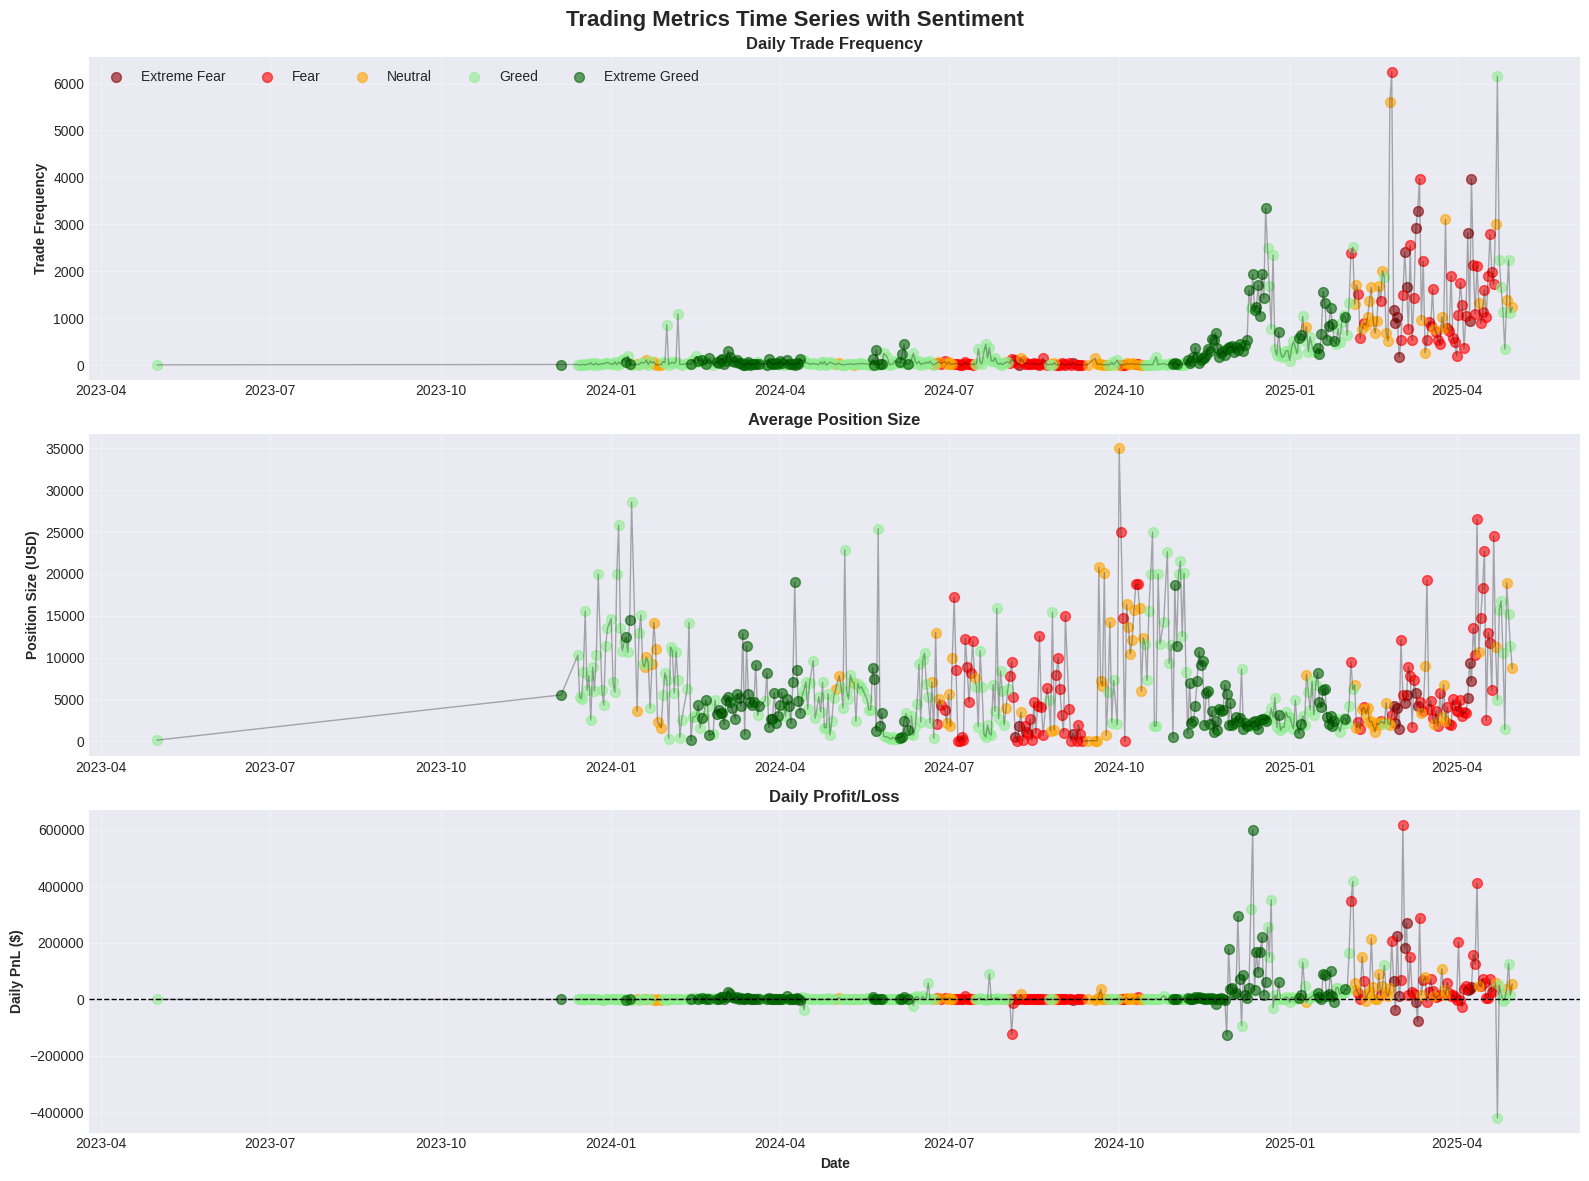

✓ Time series visualization saved as 'time_series_analysis.png'


In [13]:
# Plot key metrics over time with sentiment overlay
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Trading Metrics Time Series with Sentiment', fontsize=16, fontweight='bold')

# Prepare data sorted by date
time_data = final_dataset_clean.sort_values('date')

# Color map for sentiment
sentiment_colors = {
    'Extreme Fear': 'darkred',
    'Fear': 'red',
    'Neutral': 'orange',
    'Greed': 'lightgreen',
    'Extreme Greed': 'darkgreen'
}

# Plot 1: Trade Frequency over time
for sentiment, color in sentiment_colors.items():
    mask = time_data['sentiment_category'] == sentiment
    if mask.any():
        axes[0].scatter(time_data[mask]['date'],
                       time_data[mask]['trade_frequency'],
                       c=color, label=sentiment, alpha=0.6, s=50)
axes[0].plot(time_data['date'], time_data['trade_frequency'],
            color='black', alpha=0.3, linewidth=1)
axes[0].set_ylabel('Trade Frequency', fontweight='bold')
axes[0].set_title('Daily Trade Frequency', fontweight='bold')
axes[0].legend(loc='upper left', ncol=5)
axes[0].grid(True, alpha=0.3)

# Plot 2: Position Size over time
for sentiment, color in sentiment_colors.items():
    mask = time_data['sentiment_category'] == sentiment
    if mask.any():
        axes[1].scatter(time_data[mask]['date'],
                       time_data[mask]['avg_position_size_usd'],
                       c=color, alpha=0.6, s=50)
axes[1].plot(time_data['date'], time_data['avg_position_size_usd'],
            color='black', alpha=0.3, linewidth=1)
axes[1].set_ylabel('Position Size (USD)', fontweight='bold')
axes[1].set_title('Average Position Size', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Daily PnL over time
for sentiment, color in sentiment_colors.items():
    mask = time_data['sentiment_category'] == sentiment
    if mask.any():
        axes[2].scatter(time_data[mask]['date'],
                       time_data[mask]['daily_pnl'],
                       c=color, alpha=0.6, s=50)
axes[2].plot(time_data['date'], time_data['daily_pnl'],
            color='black', alpha=0.3, linewidth=1)
axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Daily PnL ($)', fontweight='bold')
axes[2].set_xlabel('Date', fontweight='bold')
axes[2].set_title('Daily Profit/Loss', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Time series visualization saved as 'time_series_analysis.png'")

## 10. Export Results

In [14]:
# Save summary statistics
sentiment_summary.to_csv('sentiment_summary_statistics.csv')

# Create a data dictionary
data_dictionary = pd.DataFrame({
    'Column': final_dataset_clean.columns,
    'Description': [
        'Trading date',
        'Number of trades executed on this day',
        'Average position size in USD',
        'Median position size in USD',
        'Total trading volume in USD',
        'Standard deviation of position sizes',
        'Average position size in tokens',
        'Total volume traded in tokens',
        'Total PnL for the day',
        'Average PnL per trade',
        'Average execution price',
        'Minimum execution price',
        'Maximum execution price',
        'Total fees paid',
        'Position at start of day',
        'Position at end of day',
        'Number of buy trades',
        'Number of sell trades',
        'Total USD volume from buy trades',
        'Total USD volume from sell trades',
        'Total token volume from buy trades',
        'Total token volume from sell trades',
        'Ratio of buy to sell trades (count)',
        'Ratio of buy to sell volume (USD)',
        'Net volume (buy - sell) in USD',
        'Net volume (buy - sell) in tokens',
        'Percentage of trades that are buys',
        'Maximum position size for the day',
        'Range of position sizes',
        'Estimated leverage factor',
        'Fear & Greed Index value (0-100)',
        'Sentiment category (Fear, Neutral, Greed)'
    ][:len(final_dataset_clean.columns)]
})

data_dictionary.to_csv('data_dictionary.csv', index=False)

print("\n" + "="*70)
print("="*70)
print("\nGenerated files:")
print("  1. merged_trading_sentiment_data.csv - Complete merged dataset")
print("  2. sentiment_summary_statistics.csv - Summary stats by sentiment")
print("  3. data_dictionary.csv - Column descriptions")
print("  4. trading_metrics_by_sentiment.png - Key metrics visualization")
print("  5. time_series_analysis.png - Time series plots")
print("\nDataset shape:", final_dataset_clean.shape)
print("Date range:", final_dataset_clean['date'].min(), "to", final_dataset_clean['date'].max())



Generated files:
  1. merged_trading_sentiment_data.csv - Complete merged dataset
  2. sentiment_summary_statistics.csv - Summary stats by sentiment
  3. data_dictionary.csv - Column descriptions
  4. trading_metrics_by_sentiment.png - Key metrics visualization
  5. time_series_analysis.png - Time series plots

Dataset shape: (479, 32)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


## 11. Quick Data Insights

In [15]:
print("="*70)
print("QUICK INSIGHTS")
print("="*70)

# Overall stats
print("\n1. OVERALL TRADING ACTIVITY:")
print(f"   Total trading days: {len(final_dataset_clean)}")
print(f"   Total trades: {final_dataset_clean['trade_frequency'].sum():.0f}")
print(f"   Total volume: ${final_dataset_clean['total_volume_usd'].sum():,.2f}")
print(f"   Total PnL: ${final_dataset_clean['daily_pnl'].sum():,.2f}")
print(f"   Total fees paid: ${final_dataset_clean['total_fees'].sum():,.2f}")

# By sentiment
print("\n2. PERFORMANCE BY SENTIMENT:")
for sentiment in final_dataset_clean['sentiment_category'].unique():
    subset = final_dataset_clean[final_dataset_clean['sentiment_category'] == sentiment]
    print(f"\n   {sentiment}:")
    print(f"     Days: {len(subset)}")
    print(f"     Avg trades/day: {subset['trade_frequency'].mean():.1f}")
    print(f"     Avg position size: ${subset['avg_position_size_usd'].mean():,.2f}")
    print(f"     Avg daily PnL: ${subset['daily_pnl'].mean():,.2f}")
    print(f"     Avg L/S ratio: {subset['long_short_ratio_count'].mean():.2f}")
    print(f"     Buy %: {subset['buy_percentage'].mean():.1f}%")

# Correlation with sentiment value
print("\n3. CORRELATIONS WITH SENTIMENT VALUE:")
correlations = final_dataset_clean[[
    'sentiment_value', 'trade_frequency', 'avg_position_size_usd',
    'daily_pnl', 'long_short_ratio_count', 'buy_percentage'
]].corr()['sentiment_value'].sort_values(ascending=False)

for metric, corr in correlations.items():
    if metric != 'sentiment_value':
        print(f"   {metric}: {corr:+.3f}")

print("\n" + "="*70)

QUICK INSIGHTS

1. OVERALL TRADING ACTIVITY:
   Total trading days: 479
   Total trades: 211218
   Total volume: $1,191,098,773.60
   Total PnL: $10,254,486.95
   Total fees paid: $245,849.21

2. PERFORMANCE BY SENTIMENT:

   Greed:
     Days: 193
     Avg trades/day: 260.6
     Avg position size: $6,735.30
     Avg daily PnL: $11,140.57
     Avg L/S ratio: 2.72
     Buy %: 49.3%

   Extreme Greed:
     Days: 114
     Avg trades/day: 350.8
     Avg position size: $4,410.52
     Avg daily PnL: $23,817.29
     Avg L/S ratio: 1.69
     Buy %: 45.7%

   Neutral:
     Days: 67
     Avg trades/day: 562.5
     Avg position size: $7,157.53
     Avg daily PnL: $19,297.32
     Avg L/S ratio: 2.53
     Buy %: 50.0%

   Fear:
     Days: 91
     Avg trades/day: 679.5
     Avg position size: $6,524.29
     Avg daily PnL: $36,891.82
     Avg L/S ratio: 3.23
     Buy %: 51.3%

   Extreme Fear:
     Days: 14
     Avg trades/day: 1528.6
     Avg position size: $4,091.80
     Avg daily PnL: $52,793.59
  